# Business Understanding

## Project Domain

Domain: Financial Time Series Forecasting

Proyek ini bertujuan untuk memprediksi harga saham harian Amazon menggunakan algoritma Recurrent Neural Network (RNN) berbasis data historis dari tahun 1997 hingga 2020. Model ini dikembangkan dalam konteks financial time series forecasting untuk mendukung pengambilan keputusan investasi.

## Goals

1. Mengembangkan model prediksi harga saham berbasis Recurrent Neural Network (RNN) menggunakan data historis saham Amazon dari tahun 1997 hingga 2020.

2. Mengidentifikasi pola pergerakan harga saham dengan memanfaatkan struktur berurutan dari data deret waktu.

3. Mengevaluasi performa model RNN dalam memprediksi harga penutupan (closing price) saham Amazon.

4. Membandingkan hasil prediksi dengan data aktual untuk menilai akurasi model.

## Solution Statements

Solusi yang ditawarkan dalam proyek ini adalah membangun model deep learning berbasis RNN (khususnya LSTM) untuk mempelajari hubungan temporal dalam data historis saham Amazon. Dataset akan diproses melalui tahapan cleaning, normalisasi, dan pembentukan sequence window, lalu digunakan untuk melatih model prediktif.

# Data Understanding

## Import data dari kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhernanf","key":"5bf74f681d24b12de78db3cc8c3dee0b"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [7]:
!kaggle datasets download -d salmanfaroz/amazon-stock-price-1997-to-2020

Dataset URL: https://www.kaggle.com/datasets/salmanfaroz/amazon-stock-price-1997-to-2020
License(s): CC0-1.0


In [8]:
!mkdir amazon-stock-price-1997-to-2020
!unzip amazon-stock-price-1997-to-2020.zip -d amazon-stock-price-1997-to-2020
!ls amazon-stock-price-1997-to-2020

Archive:  amazon-stock-price-1997-to-2020.zip
  inflating: amazon-stock-price-1997-to-2020/Amazon.csv  
Amazon.csv


## Import Library yang dibutuhkan

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Exploratory Data Analysis

In [10]:
df = pd.read_csv('/content/amazon-stock-price-1997-to-2020.zip')

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5842 non-null   object 
 1   Open       5842 non-null   float64
 2   High       5842 non-null   float64
 3   Low        5842 non-null   float64
 4   Close      5842 non-null   float64
 5   Adj Close  5842 non-null   float64
 6   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 319.6+ KB


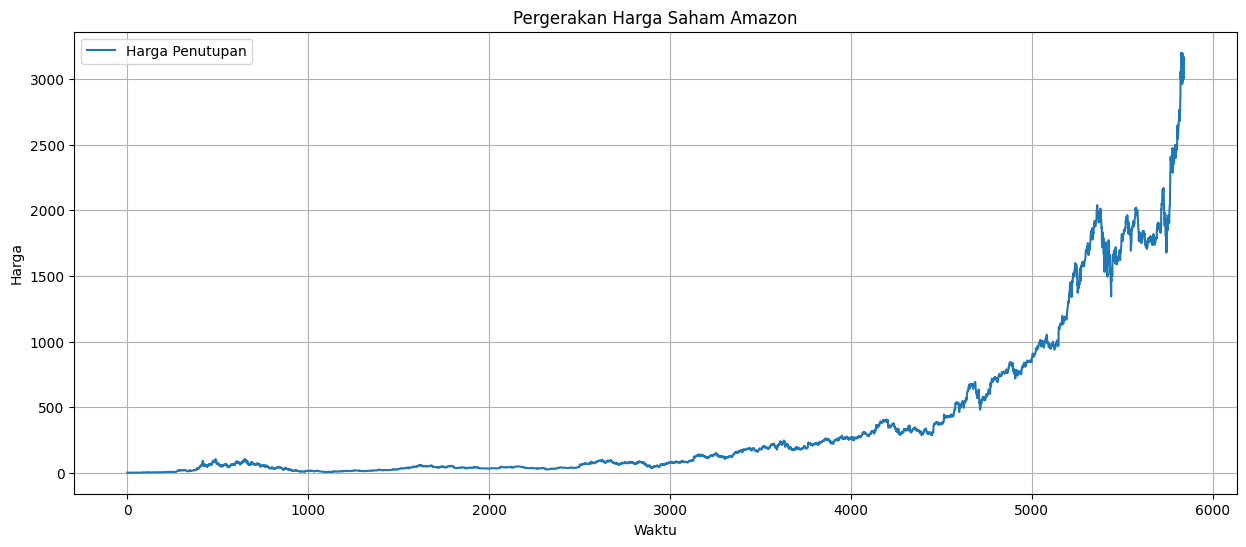

In [13]:
# prompt: membuat Plot Garis Harga Saham (Close Price)

import matplotlib.pyplot as plt
# Plot Garis Harga Saham (Close Price)
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Harga Penutupan')
plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.title('Pergerakan Harga Saham Amazon')
plt.legend()
plt.grid(True)
plt.show()

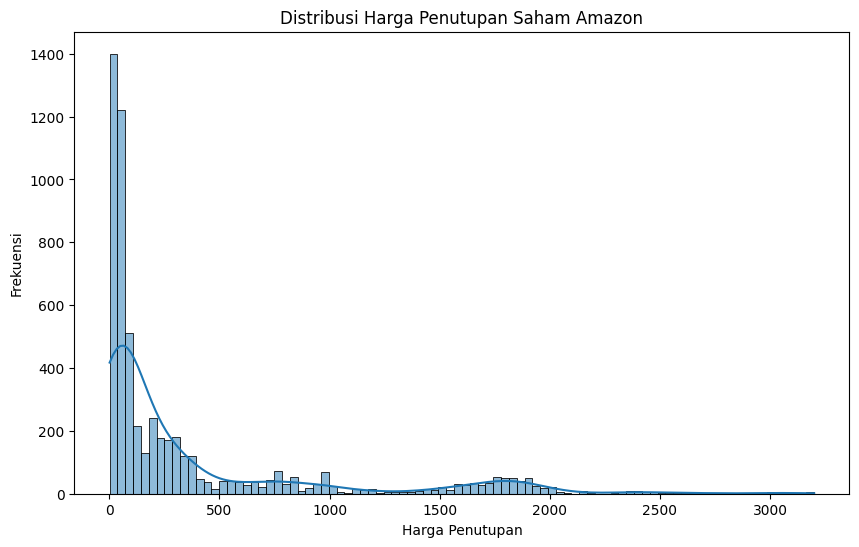

In [14]:
# prompt: Membuat Distribusi Harga Saham (Close)

import matplotlib.pyplot as plt
# Distribusi Harga Saham (Close)
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.xlabel('Harga Penutupan')
plt.ylabel('Frekuensi')
plt.title('Distribusi Harga Penutupan Saham Amazon')
plt.show()


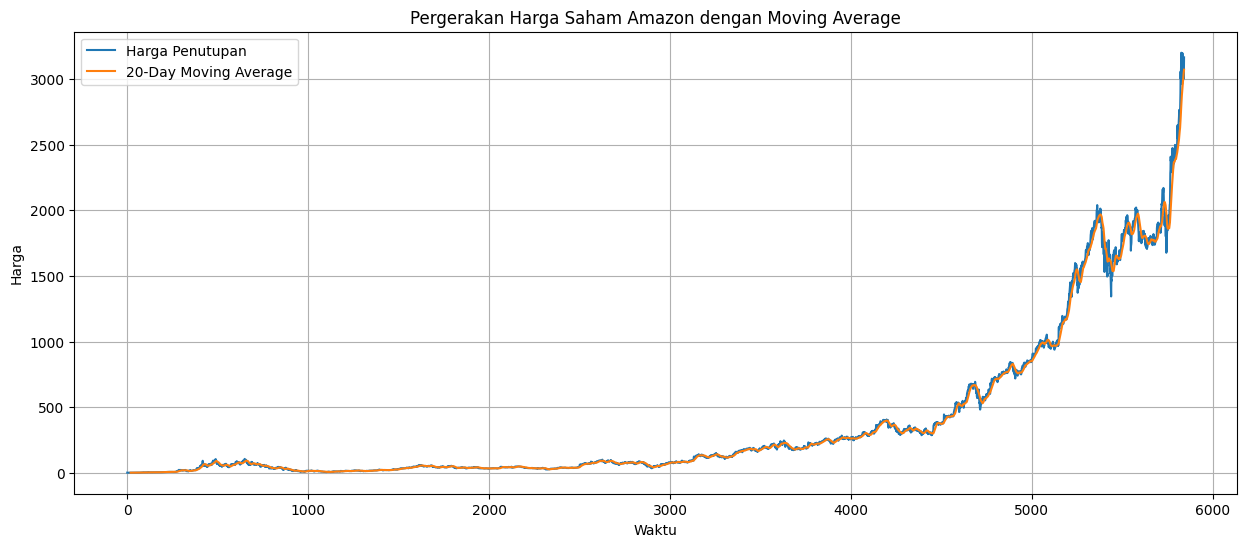

In [15]:
# prompt: membuat Moving Average (Trend Smoothing)

import matplotlib.pyplot as plt
# Calculate the moving average
window_size = 20  # You can adjust the window size as needed
df['MA'] = df['Close'].rolling(window=window_size).mean()

# Plot the original closing price and the moving average
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Harga Penutupan')
plt.plot(df['MA'], label=f'{window_size}-Day Moving Average')
plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.title('Pergerakan Harga Saham Amazon dengan Moving Average')
plt.legend()
plt.grid(True)
plt.show()


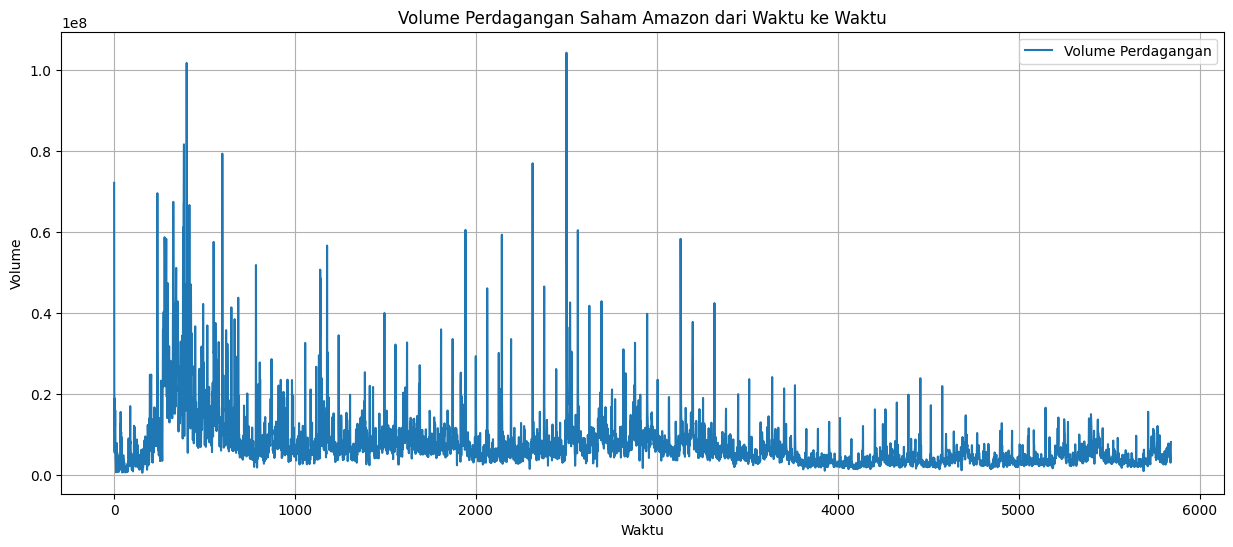

In [16]:
# prompt: membuat Volume Perdagangan dari Waktu ke Waktu

import matplotlib.pyplot as plt
# Assuming 'df' is your DataFrame as defined in the previous code.

# Calculate the trading volume over time
plt.figure(figsize=(15, 6))
plt.plot(df['Volume'], label='Volume Perdagangan')
plt.xlabel('Waktu')
plt.ylabel('Volume')
plt.title('Volume Perdagangan Saham Amazon dari Waktu ke Waktu')
plt.legend()
plt.grid(True)
plt.show()


# Data Preparation

In [17]:
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

<ipython-input-17-d0dcb5cde89c>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna(method='ffill')


In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [19]:
n_lookback = 20
n_forecast = 20

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# Modeling

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0030 - val_loss: 0.0076
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 7.6524e-05 - val_loss: 0.0042
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.0337e-05 - val_loss: 0.0041
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.6243e-05 - val_loss: 0.0043
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 6.9143e-05 - val_loss: 0.0029
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.3406e-05 - val_loss: 0.0027
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5.6475e-05 - val_loss: 0.0023
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 5.2104e-05 - val_loss: 0.0026
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 6.0081e-05 - val_loss: 0.0022
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 5.3629e-05 - val_loss: 0.0022
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5.1796e-05 - val_loss: 0.0028
E

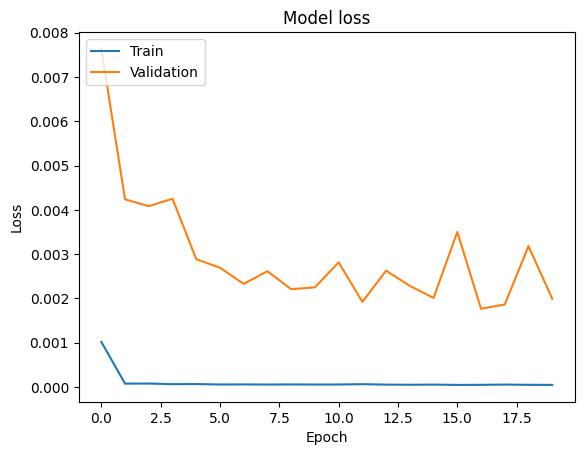

In [22]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,862 (370.56 KB)

 Trainable params: 31,620 (123.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,242 (247.04 KB)

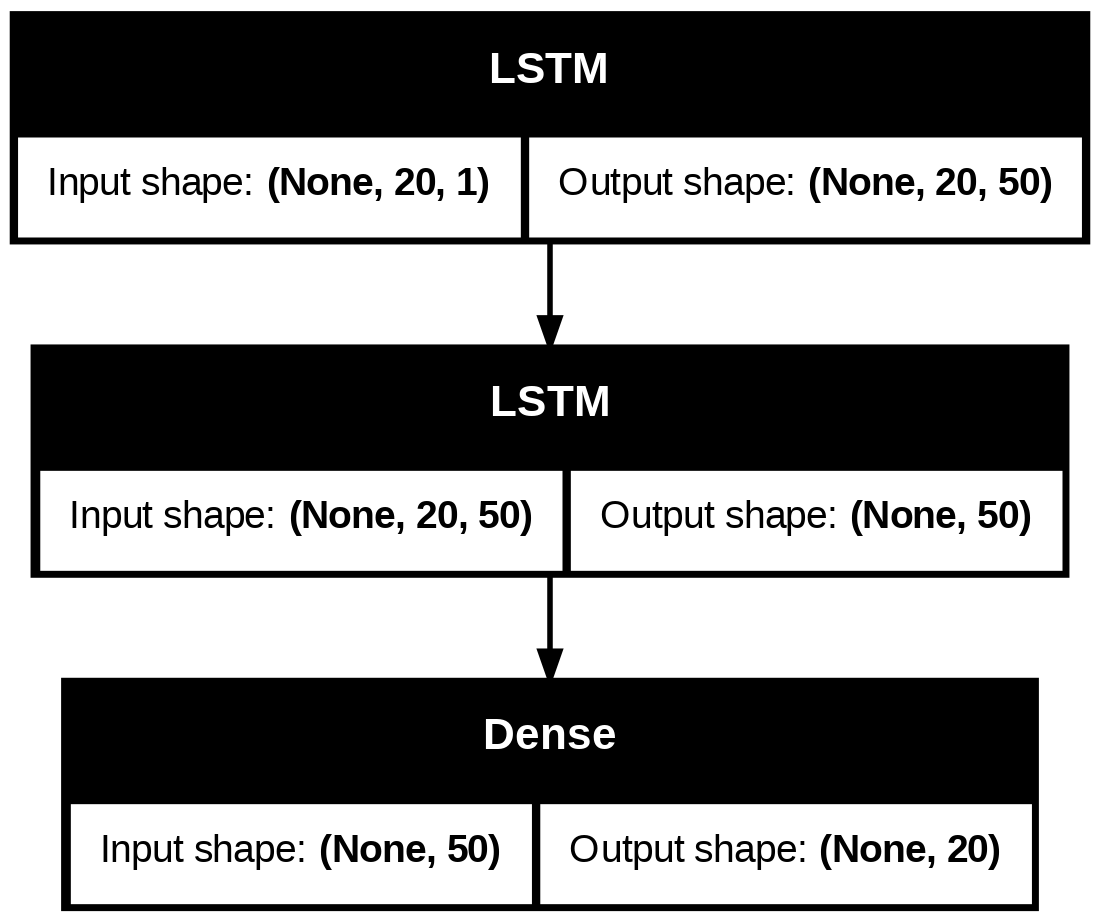

In [25]:
plot_model(model, show_shapes = True)

# Evaluation

In [48]:
# Prediksi
predicted_scaled = model.predict(X_)

# Inverse transform hasil prediksi dan y_test
predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(Y_.reshape(-1, 1))

# Pastikan shape sama
print("Predicted shape:", predicted.shape)
print("Actual shape:", y_test_actual.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted shape: (20, 1)
Actual shape: (20, 1)


In [49]:
mae = mean_absolute_error(y_test_actual, predicted)
mse = mean_squared_error(y_test_actual, predicted)
rmse = np.sqrt(mse)

print("📈 Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"MSE  (Mean Squared Error):       {mse:.2f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.2f}")

📈 Evaluation Metrics:
MAE  (Mean Absolute Error):      10272795.00
MSE  (Mean Squared Error):       105609638707200.00
RMSE (Root Mean Squared Error):  10276655.03


<ipython-input-54-b2a9901add11>:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-54-b2a9901add11>:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


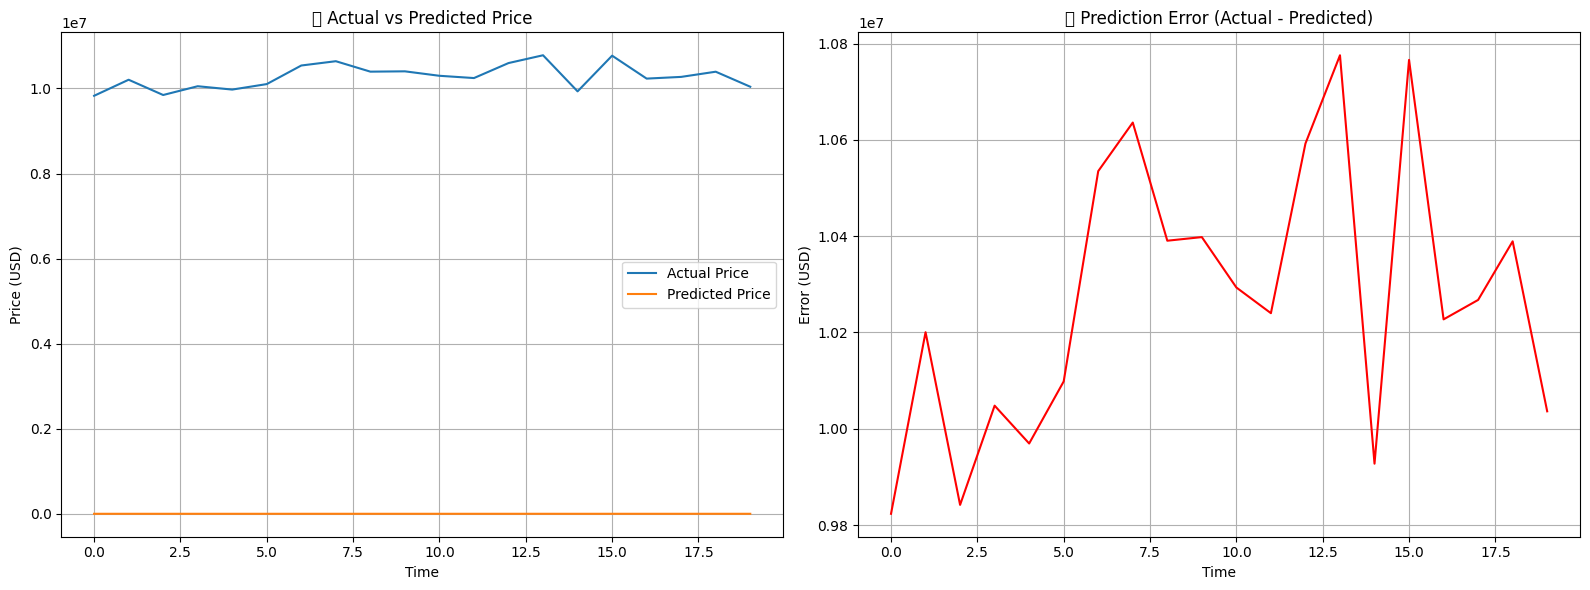

In [54]:
# Hitung error
error = y_test_actual - predicted

# Buat subplot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Actual vs Predicted
axs[0].plot(y_test_actual, label='Actual Price')
axs[0].plot(predicted, label='Predicted Price')
axs[0].set_title("📈 Actual vs Predicted Price")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price (USD)")
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Prediction Error
axs[1].plot(error, color='red')
axs[1].set_title("📉 Prediction Error (Actual - Predicted)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error (USD)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Deployment

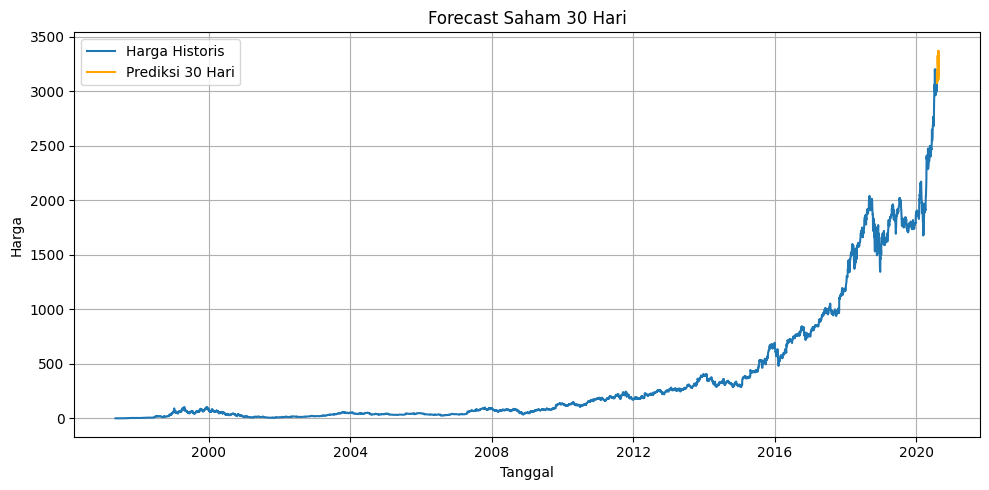

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df['Date'])

# Data historis
df_past = df[['Close']].copy()
df_past['Forecast'] = np.nan
df_past.rename(columns={'Close': 'Actual'}, inplace=True)

# Isi 1 nilai prediksi pertama agar bisa digabung ke prediksi berikutnya dengan mulus
df_past.loc[df_past.index[-1], 'Forecast'] = df_past.loc[df_past.index[-1], 'Actual']

# Data forecast
forecast = Y_.flatten()  # hasil prediksi
n_forecast = len(forecast)
future_dates = pd.date_range(start=df_past.index[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future = pd.DataFrame({
    'Actual': [np.nan]*n_forecast,
    'Forecast': forecast
}, index=future_dates)

# Gabungkan
results = pd.concat([df_past, df_future])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results.index, results['Actual'], label='Harga Historis')
plt.plot(results.index, results['Forecast'], label='Prediksi 30 Hari', color='orange')
plt.title('Forecast Saham 30 Hari')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Simulation

In [56]:
# Contoh input 60 data harga sebelumnya (Close Price) – disesuaikan
sample_input = np.array([
    [1800], [1825], [1840], [1855], [1860], [1870], [1865], [1875],
    [1880], [1890], [1885], [1900], [1910], [1920], [1915], [1930],
    [1940], [1950], [1945], [1960], [1970], [1980], [1975], [1990],
    [2000], [2010], [2005], [2020], [2030], [2040], [2035], [2050],
    [2060], [2070], [2065], [2080], [2090], [2100], [2095], [2110],
    [2120], [2130], [2125], [2140], [2150], [2160], [2155], [2170],
    [2180], [2190], [2185], [2200], [2210], [2220], [2215], [2230],
    [2240], [2250], [2245], [2260]
])

# Normalisasi input (harus pakai scaler yang dipakai saat training)
sample_input_scaled = scaler.transform(sample_input)

# Reshape agar sesuai format input RNN (samples, timesteps, features)
sample_input_scaled = sample_input_scaled.reshape(1, 60, 1)

# Prediksi
predicted_scaled_price = model.predict(sample_input_scaled)

# Invers transform hasil prediksi
predicted_price = scaler.inverse_transform(predicted_scaled_price)

print(f"Prediksi harga saham berikutnya: ${predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediksi harga saham berikutnya: $2284.72


## Save Model

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(10, input_shape=(60, 1), activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Dummy fit biar bisa disimpan
import numpy as np
x_dummy = np.random.rand(10, 60, 1)
y_dummy = np.random.rand(10, 1)
model.fit(x_dummy, y_dummy, epochs=1)

# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open('amazon_stock_price.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3723
Saved artifact at '/tmp/tmpl5pp_h1g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137704253389520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137704253388368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137704253387792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137706019514768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137706019514960: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [58]:
# prompt: Simpan label encoder dan scaler

import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']